In [1]:
from scprint import scPrint
from scdataloader import Preprocessor

from bengrn import BenGRN, get_sroy_gt, FILEDIR
import scanpy as sc

from anndata.utils import make_index_unique
from bengrn import compute_genie3, get_GT_db
from grnndata import utils as grnutils
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint


In [2]:
from grnndata import GRNAnnData

import sys
sys.path.append("../tools/DeepSEM")

from src.DeepSEM_cell_type_test_specific_GRN_model import celltype_GRN_model as test_celltype_GRN_model

class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def run_deepsem(adata):
    import random
    import string

    def generate_random_hash(length=3):
        """Generate a random hash of specified length."""
        characters = string.ascii_letters + string.digits
        return ''.join(random.choice(characters) for _ in range(length))

    random_hash = generate_random_hash()
    opt = DotDict({
        'beta': 0.01,
        'alpha': 1,
        'K1': 1,
        'K2': 2,
        'K': 1,
        'net_file': "",
        'n_epochs': 50,
        'n_hidden': 128,
        'gamma': 0.95,
        'lr': 1e-4,
        'lr_step_size': 0.99,
        'batch_size': 64,
        'data_file': "/tmp/deepsem_"+random_hash+".h5ad",
        'save_name': "/tmp/deepsem/",
        'task': "celltype_GRN"
    })
    adata.X = adata.X.toarray()
    adata.write("/tmp/deepsem_"+random_hash+".h5ad")
    model = test_celltype_GRN_model(opt)
    net = model.train_model()
    grn = GRNAnnData(adata.copy(), grn=net)
    del net
    return grn

In [3]:
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
NUM_GENES = 5000
MAXCELLS = 1024

# han / full


In [4]:
metrics = {}

In [5]:
preadata = get_sroy_gt(get="han", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata = adata[:, adata.var.index.isin(genes)]
preadata, (preadata.grn.sum(1) != 0).sum()

100%|██████████| 12986/12986 [00:00<00:00, 13070.11it/s]


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 5520 renamining
filtered out 0 cells, 5520 renamining
No ENSG genes found, assuming gene symbols...
Removed 0 genes.
startin QC
Seeing 151 outliers (2.74% of total dataset):
done


(GRnnData object with n_obs × n_vars = 5520 × 7465
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 8463 elements,
 31)

In [6]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.highly_variable]

grn = run_deepsem(subadata)
grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

save dir exist


/home/ml4ig1/Documents code/scPRINT/notebooks/../tools/DeepSEM/src/DeepSEM_cell_type_test_specific_GRN_model.py:49: RuntimeWarning: Mean of empty slice.
  means.append(tmp[tmp != 0].mean())
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/

epoch: 1 0.3480710778385401 mse_loss: 0.3048016931861639 kl_loss: 0.042713817150797695 sparse_loss: 0.0005555733623623382
epoch: 2 0.3154585789889097 mse_loss: 0.26495487801730633 kl_loss: 0.049857861711643636 sparse_loss: 0.00064585065774736
epoch: 4 0.17820935510098934 mse_loss: 0.1352978963404894 kl_loss: 0.04221746220719069 sparse_loss: 0.0006939917984709609
epoch: 5 0.18640339700505137 mse_loss: 0.14156807027757168 kl_loss: 0.044102019746787846 sparse_loss: 0.000733301363652572
epoch: 7 0.15530835697427392 mse_loss: 0.11236994713544846 kl_loss: 0.04218467744067311 sparse_loss: 0.0007537305791629478
epoch: 8 0.14840973680838943 mse_loss: 0.10490171145647764 kl_loss: 0.04274050425738096 sparse_loss: 0.0007675155939068645
epoch: 10 0.13066664664074779 mse_loss: 0.08681631530635059 kl_loss: 0.04307351436000317 sparse_loss: 0.0007768149953335524
epoch: 11 0.12665241165086627 mse_loss: 0.08249110076576471 kl_loss: 0.0433772198157385 sparse_loss: 0.0007840881589800119
epoch: 13 0.1245203

precision:  0.027305461092218444 
recall:  0.9970119521912351 
random precision: 0.02738729564094637


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2058.26it/s]

Average Precision (AP):  0.02680245840883502
Area Under Precision-Recall Curve (AUPRC):  0.026767613473237528
EPR: 0.9426301607414935


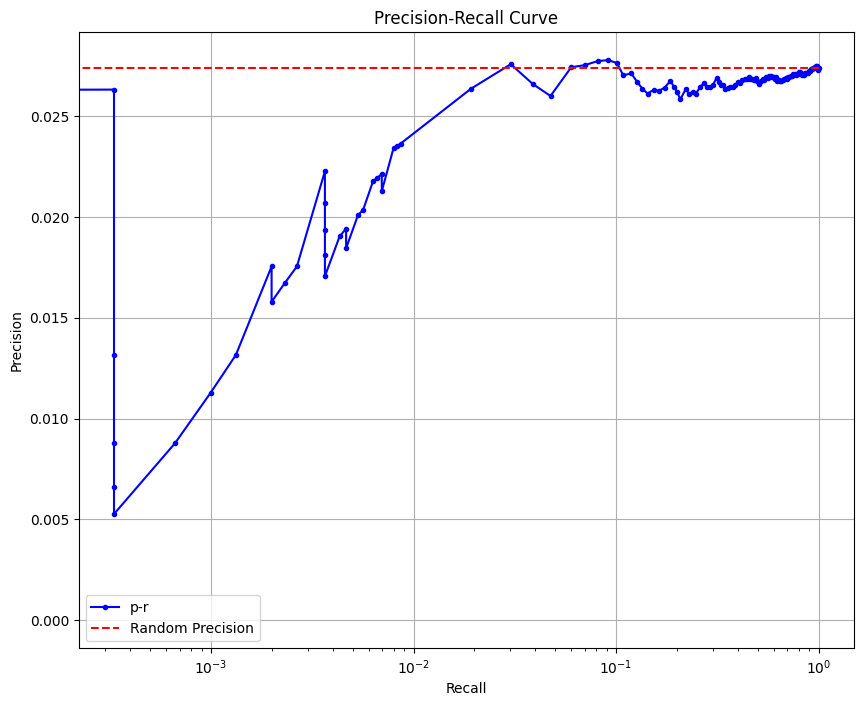

In [7]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_han'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment
Top central genes: []


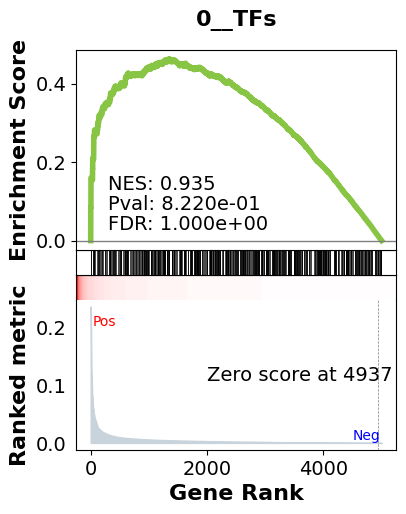

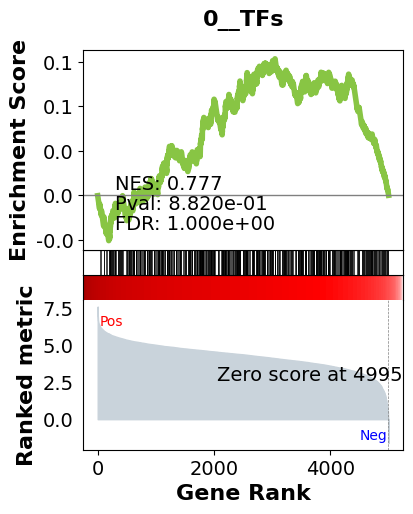

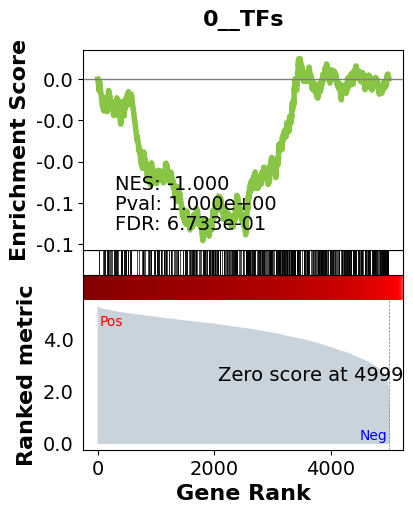

_________________________________________
TF specific enrichment
found some significant results for  32.075471698113205 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3764 genes
intersection pct: 0.7528
precision:  0.0015159632226418483 
recall:  0.9999068641147434 
random precision: 0.0015161044263697398


 98%|█████████▊| 125/128 [00:02<00:00, 45.39it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 45.26it/s]


Average Precision (AP):  0.0014790992695324118
Area Under Precision-Recall Curve (AUPRC):  0.001478421383902492
EPR: 0.9520428965974892


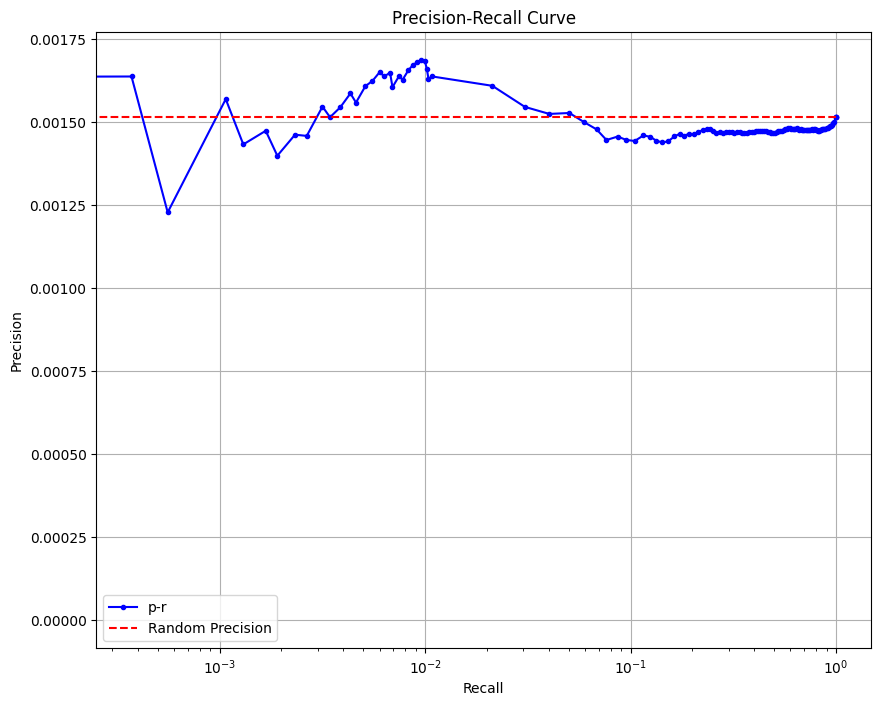

In [8]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

100%|██████████| 780470/780470 [00:18<00:00, 42466.68it/s] 


precision:  0.2533531096463195 
recall:  0.9995187865722205 
random precision: 0.25347508526095464


 52%|█████▏    | 66/128 [00:00<00:00, 656.56it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 650.96it/s]


Average Precision (AP):  0.2380750578278785
Area Under Precision-Recall Curve (AUPRC):  0.23803000381222295
EPR: 0.860149919938969


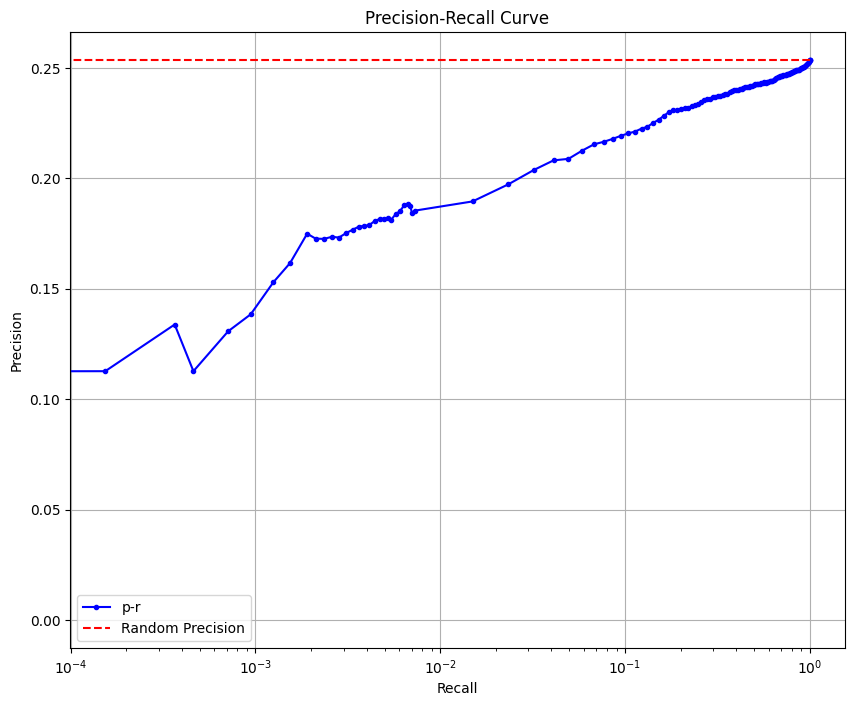

In [9]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

100%|██████████| 201805/201805 [00:08<00:00, 24543.75it/s]


precision:  0.07581693329816405 
recall:  0.998577723891907 
random precision: 0.07592491949717377


 72%|███████▏  | 92/128 [00:00<00:00, 452.13it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 453.54it/s]


Average Precision (AP):  0.07042573508694729
Area Under Precision-Recall Curve (AUPRC):  0.07040045637878578
EPR: 0.8970970305122886


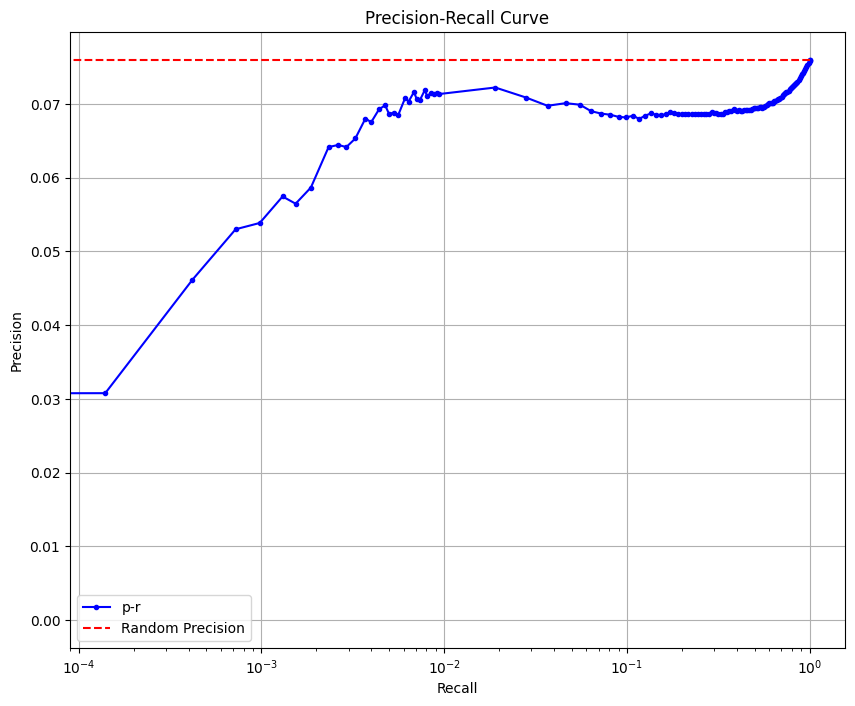

In [10]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['deepsem_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## trial with my own ESC

In [11]:
preadata = get_sroy_gt(get="mine", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

100%|██████████| 12986/12986 [00:06<00:00, 1985.94it/s]


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 115 renamining
filtered out 0 cells, 115 renamining
Removed 0 genes.
startin QC
Seeing 104 outliers (90.43% of total dataset):
done


(GRnnData object with n_obs × n_vars = 115 × 28490
     obs: 'organism_ontology_term_id'
     var: 'ensembl_id'
     varp: 'GRN'
     with a grn of 11565 elements,
 35)

save dir exist
epoch: 1 0.8148223757743835 mse_loss: 0.7903002202510834 kl_loss: 0.024167929135728627 sparse_loss: 0.00035421058419160545
epoch: 2 0.8018749058246613 mse_loss: 0.7772161066532135 kl_loss: 0.02422676741844043 sparse_loss: 0.0004320332664065063
epoch: 4 0.6104382276535034 mse_loss: 0.5842261612415314 kl_loss: 0.025713317678309977 sparse_loss: 0.0004986968997400254
epoch: 5 0.5902628302574158 mse_loss: 0.5634154379367828 kl_loss: 0.02626322105061263 sparse_loss: 0.0005841483944095671
epoch: 7 0.36996257305145264 mse_loss: 0.3402789533138275 kl_loss: 0.029021973256021738 sparse_loss: 0.0006616559985559434
epoch: 8 0.33307890594005585 mse_loss: 0.3020077496767044 kl_loss: 0.03031885903328657 sparse_loss: 0.000752300227759406
epoch: 10 0.22488341480493546 mse_loss: 0.1905435398221016 kl_loss: 0.033518478740006685 sparse_loss: 0.0008213937981054187
epoch: 11 0.20955490320920944 mse_loss: 0.17395011335611343 kl_loss: 0.03472481947392225 sparse_loss: 0.000879964791238308
epoch: 

  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 4062.31it/s]

Average Precision (AP):  0.04112128853855798
Area Under Precision-Recall Curve (AUPRC):  0.041083055656031056
EPR: 1.4813972727187723


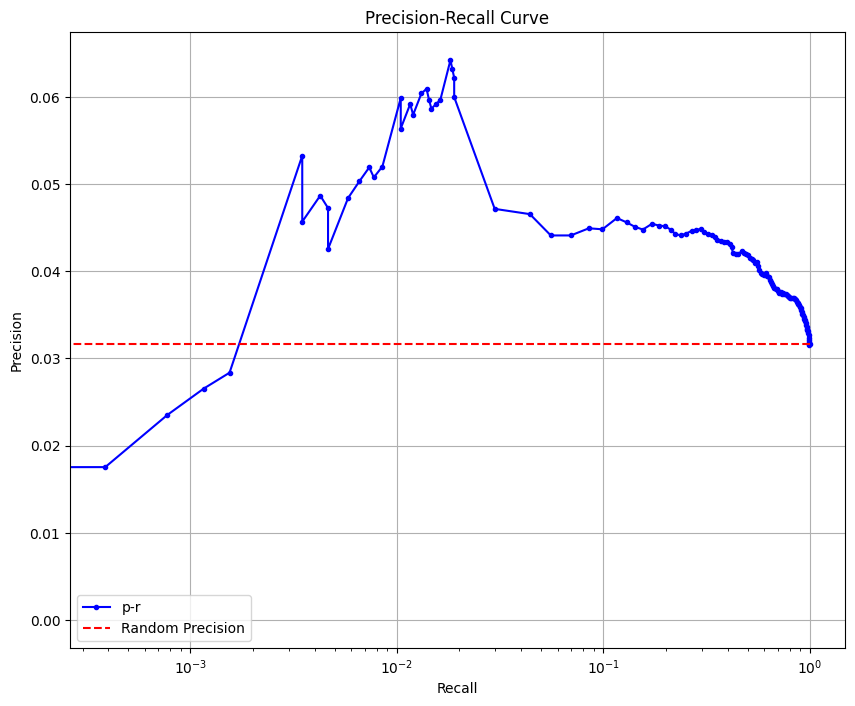

base enrichment
Top central genes: []


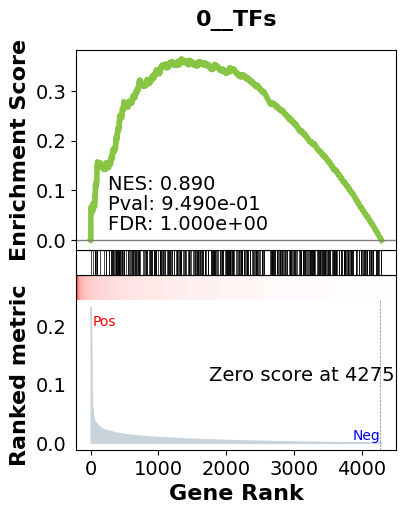

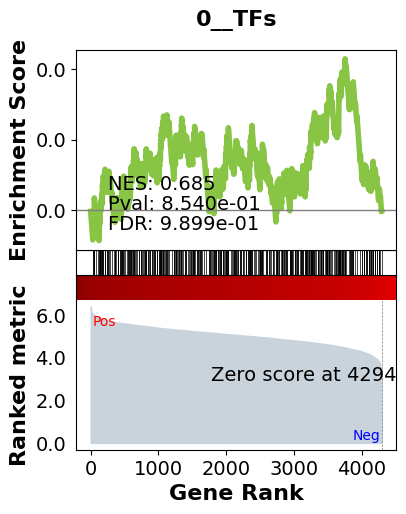

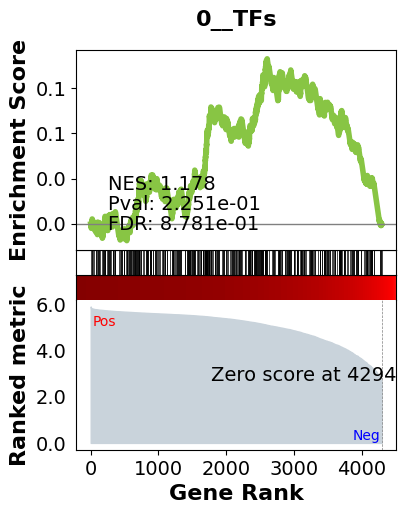

_________________________________________
TF specific enrichment
found some significant results for  45.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2830 genes
intersection pct: 0.6589057043073341
precision:  0.0015285901821992564 
recall:  0.9999182939782661 
random precision: 0.0015287150874274144


 98%|█████████▊| 126/128 [00:01<00:00, 85.65it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 85.17it/s]


Average Precision (AP):  0.0017053199233620076
Area Under Precision-Recall Curve (AUPRC):  0.0017041142908344217
EPR: 1.8217749389483662


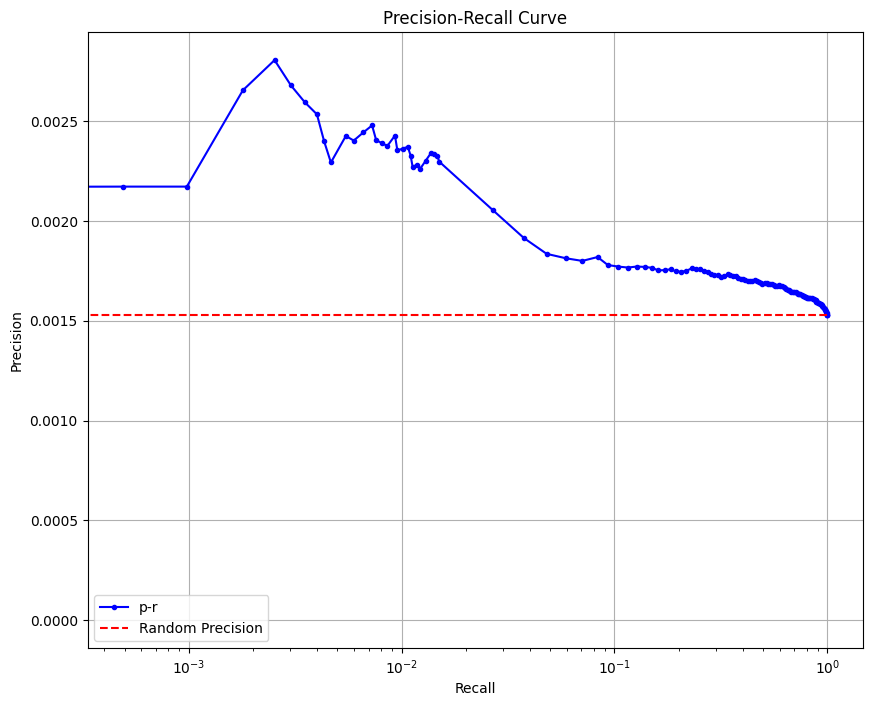

In [12]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]

grn = run_deepsem(subadata)

grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_mine'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

base enrichment


Top central genes: []


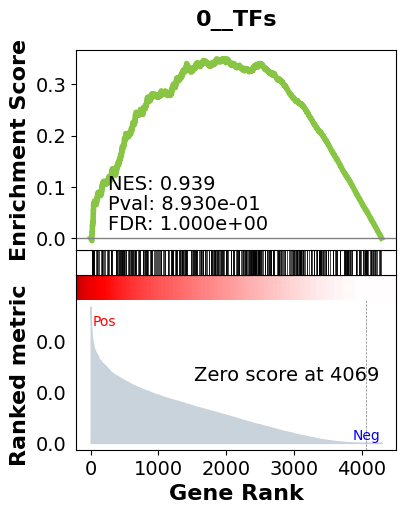

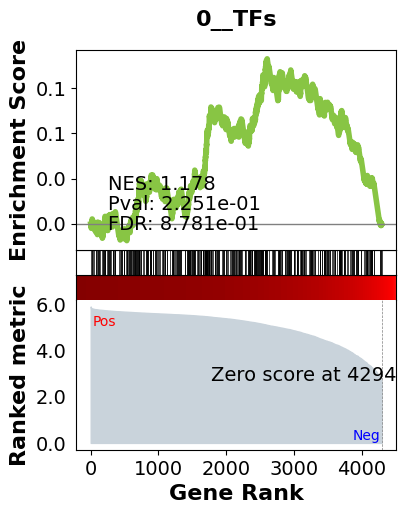

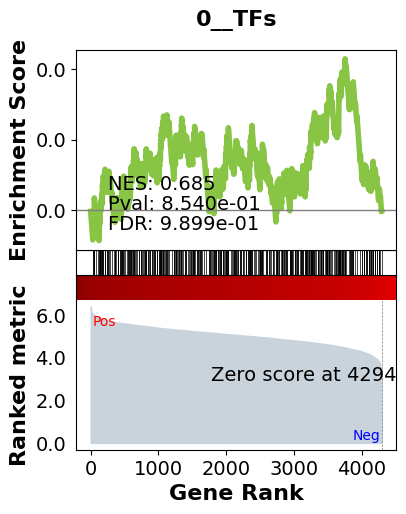

_________________________________________
TF specific enrichment
found some significant results for  5.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2830 genes
intersection pct: 0.6589057043073341
precision:  0.0015285901821992564 
recall:  0.9999182939782661 
random precision: 0.0015287150874274144


 98%|█████████▊| 126/128 [00:01<00:00, 81.06it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 81.81it/s]


Average Precision (AP):  0.0016959301848768786
Area Under Precision-Recall Curve (AUPRC):  0.0016958332661936167
EPR: 1.4450443156275383


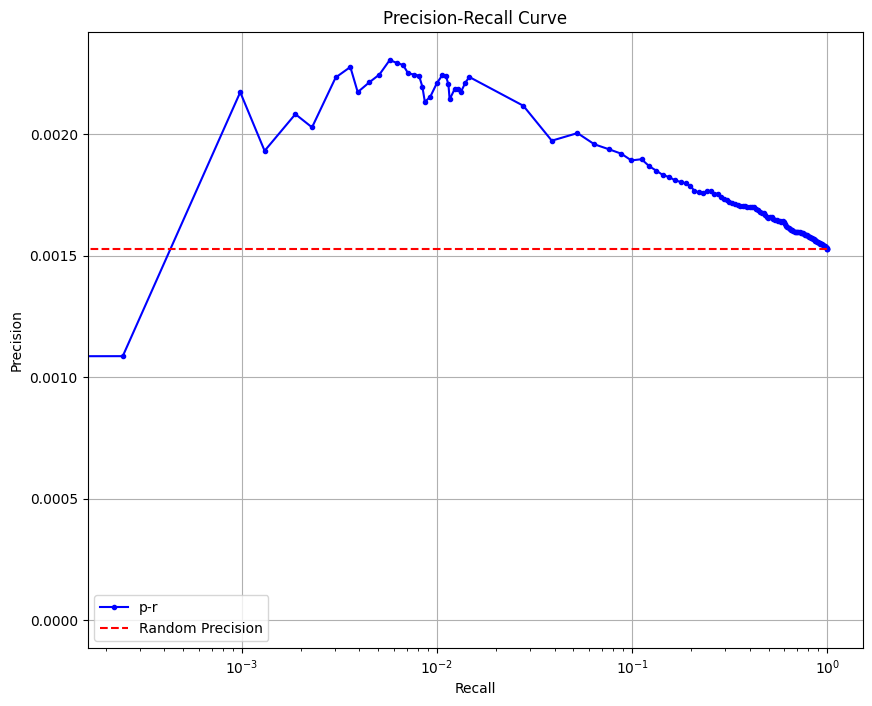

In [13]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads


Elapsed time: 93.52 seconds
precision:  0.03629649471911832 
recall:  0.7332817935833011 
random precision: 0.031708871620130905


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 3641.51it/s]

Average Precision (AP):  0.038330641321229576
Area Under Precision-Recall Curve (AUPRC):  0.03720113854079027
EPR: 1.5505429153841288


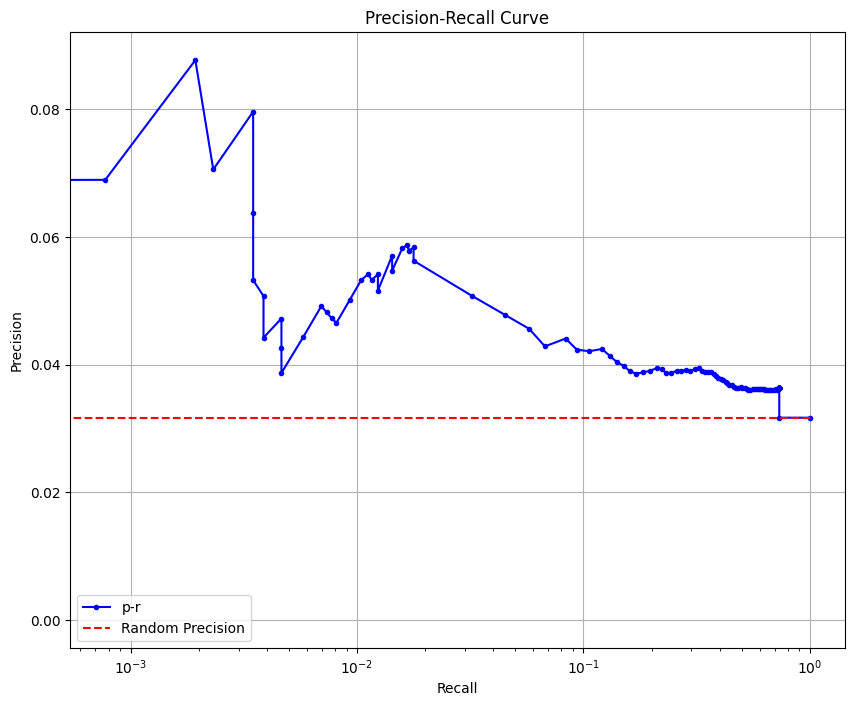

In [14]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
grn = compute_genie3(subadata, nthreads=20)
grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_mine'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment
Top central genes: []


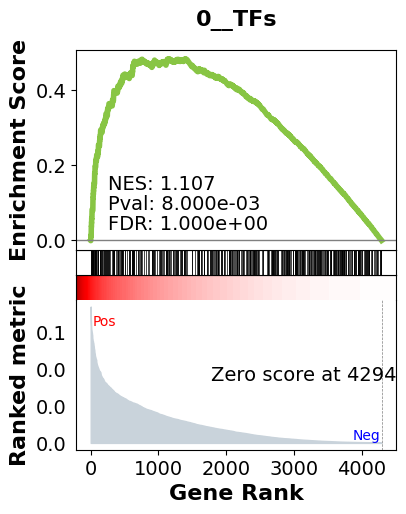

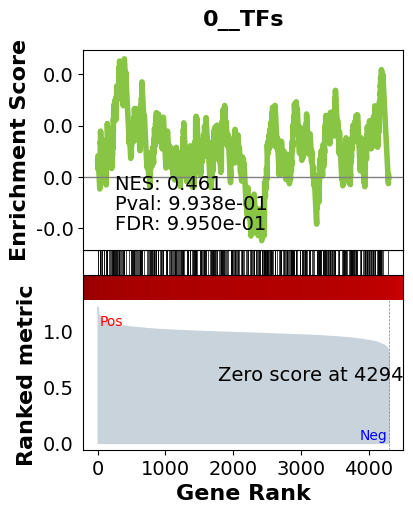

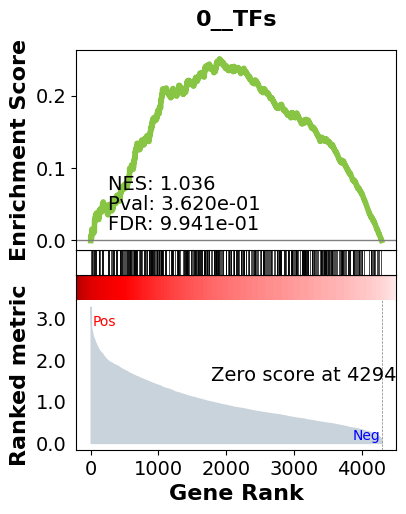

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2830 genes
intersection pct: 0.6589057043073341
precision:  0.0017214396758622867 
recall:  0.5969441947871558 
random precision: 0.0015287150874274144


 94%|█████████▍| 120/128 [00:01<00:00, 70.86it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 71.10it/s]


Average Precision (AP):  0.0017559649503738712
Area Under Precision-Recall Curve (AUPRC):  0.0017158869265422312
EPR: 1.5525935294239963


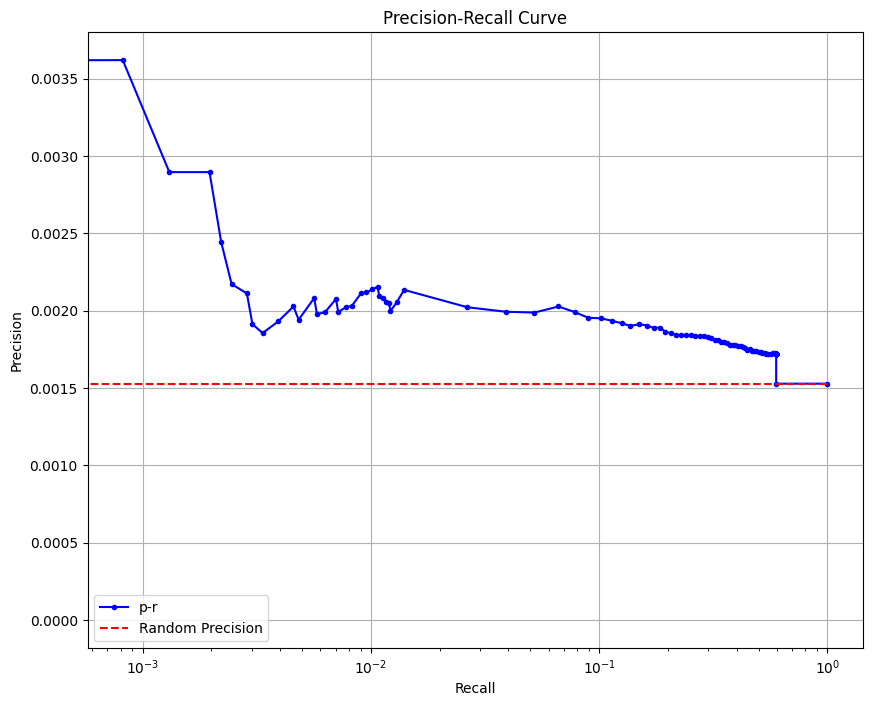

In [15]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['genie3_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

## trial with the other two mouse dataset

In [16]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

100%|██████████| 11634/11634 [00:00<00:00, 15825.65it/s]


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 2369 renamining
filtered out 0 cells, 2369 renamining
No ENSG genes found, assuming gene symbols...
Removed 0 genes.
startin QC
Seeing 91 outliers (3.84% of total dataset):
done


(GRnnData object with n_obs × n_vars = 2369 × 6618
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 7162 elements,
 31)

save dir exist


/home/ml4ig1/Documents code/scPRINT/notebooks/../tools/DeepSEM/src/DeepSEM_cell_type_test_specific_GRN_model.py:49: RuntimeWarning: Mean of empty slice.
  means.append(tmp[tmp != 0].mean())
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/

epoch: 1 0.3349582962691784 mse_loss: 0.28030215110629797 kl_loss: 0.05417056736769155 sparse_loss: 0.0004855818369833287
epoch: 2 0.30608974397182465 mse_loss: 0.24725256115198135 kl_loss: 0.058302505407482386 sparse_loss: 0.0005346766665752511
epoch: 4 0.21141855418682098 mse_loss: 0.1579279862344265 kl_loss: 0.052941099856980145 sparse_loss: 0.0005494646247825585
epoch: 5 0.22474080976098776 mse_loss: 0.17044896399602294 kl_loss: 0.05372891610022634 sparse_loss: 0.0005629256265820004
epoch: 7 0.20357025880366564 mse_loss: 0.15572291146963835 kl_loss: 0.047275131335482 sparse_loss: 0.0005722111600334756
epoch: 8 0.21823321469128132 mse_loss: 0.17007657792419195 kl_loss: 0.047576082637533545 sparse_loss: 0.0005805509063065983
epoch: 10 0.18667860981076956 mse_loss: 0.14296601014211774 kl_loss: 0.04312318412121385 sparse_loss: 0.0005894117202842608
epoch: 11 0.17687363270670176 mse_loss: 0.13276817928999662 kl_loss: 0.04350933793466538 sparse_loss: 0.0005961113893135916
epoch: 13 0.141

  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1564.88it/s]

Average Precision (AP):  0.05415192816564517
Area Under Precision-Recall Curve (AUPRC):  0.05403877408098963
EPR: 1.9672764697552778


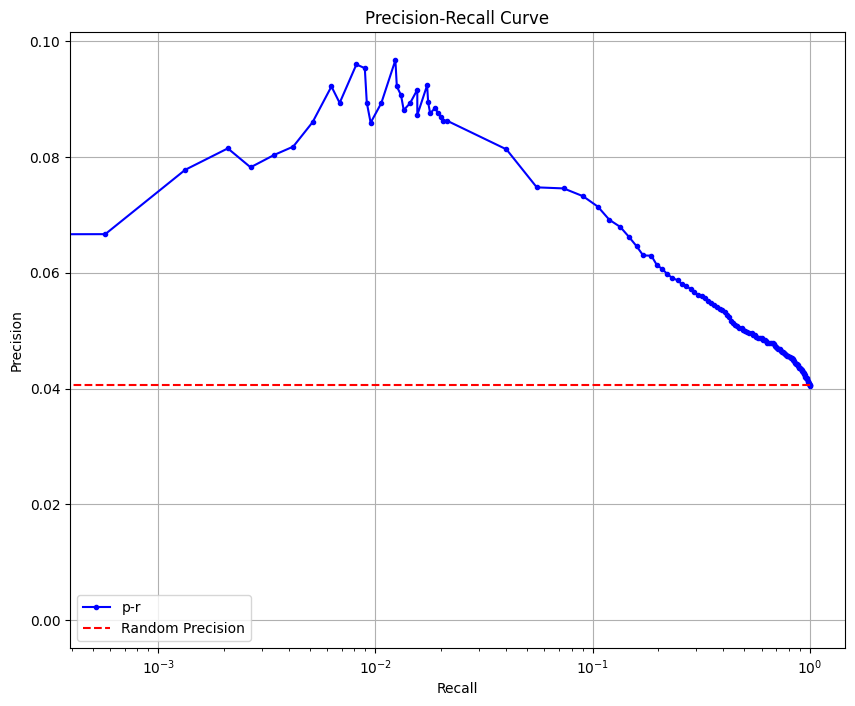

In [17]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
grn = run_deepsem(subadata)
grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_tran'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

100%|██████████| 197597/197597 [00:04<00:00, 39552.94it/s]


precision:  0.19809205251553416 
recall:  0.9996206972848247 
random precision: 0.19816721787933453


 72%|███████▏  | 92/128 [00:00<00:00, 910.41it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 902.05it/s]

Average Precision (AP):  0.19392160430151847
Area Under Precision-Recall Curve (AUPRC):  0.19377059289825838
EPR: 0.9616691949004008


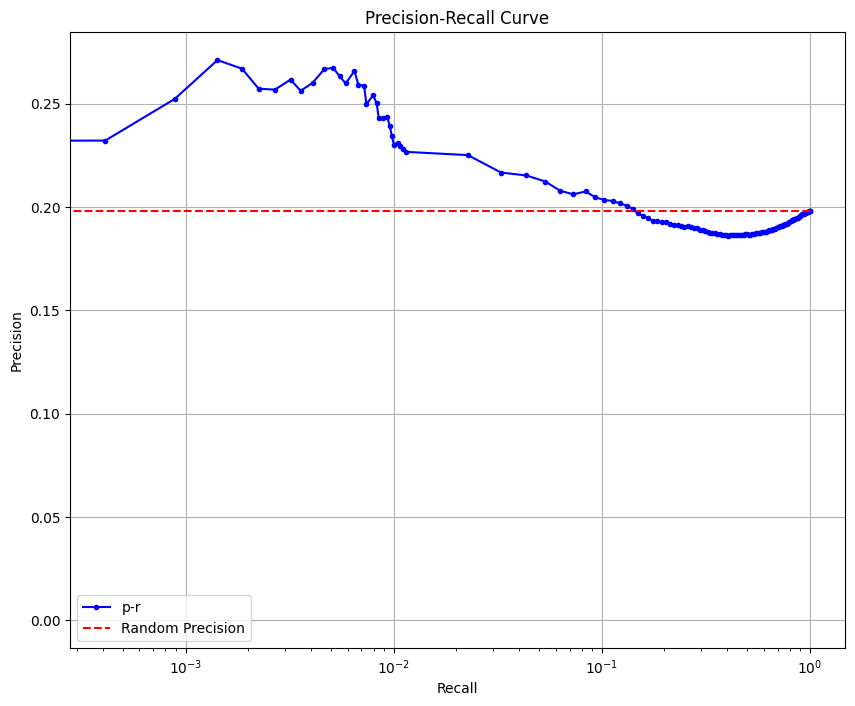

In [18]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['deepsem_tran_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

100%|██████████| 201873/201873 [00:05<00:00, 35439.49it/s]


precision:  0.0818837156028978 
recall:  0.9985377883503197 
random precision: 0.08200362225467457


 70%|███████   | 90/128 [00:00<00:00, 444.62it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 443.76it/s]


Average Precision (AP):  0.09172729484913142
Area Under Precision-Recall Curve (AUPRC):  0.0916803884227426
EPR: 1.340599776915968


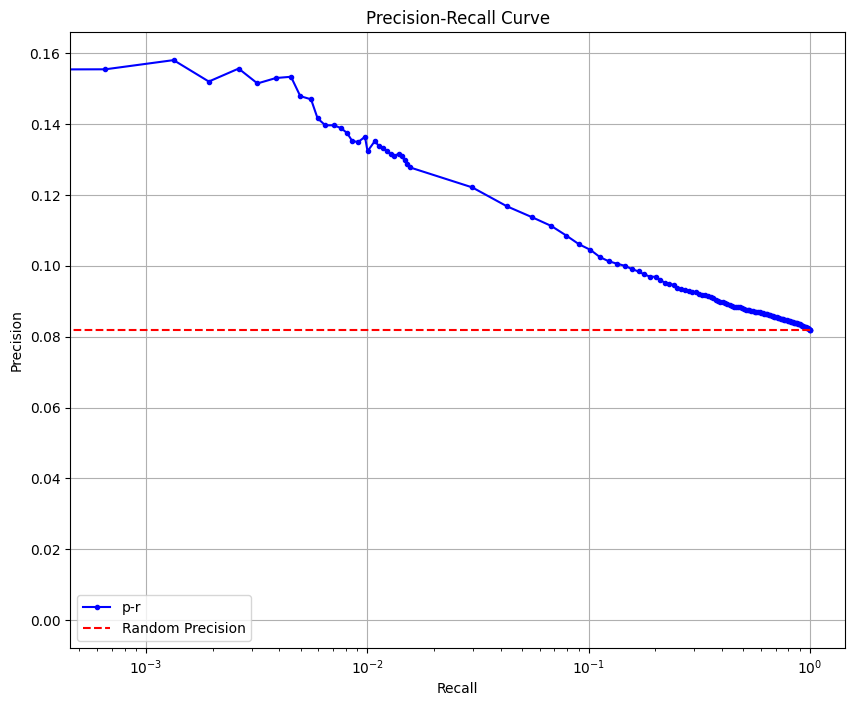

In [19]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['deepsem_tran_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# zhao

In [20]:
preadata = get_sroy_gt(get="zhao", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

100%|██████████| 11634/11634 [00:01<00:00, 9867.61it/s]


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 36199 renamining
filtered out 63 cells, 36136 renamining
No ENSG genes found, assuming gene symbols...
Removed 0 genes.
startin QC
Seeing 768 outliers (2.13% of total dataset):
done


(GRnnData object with n_obs × n_vars = 36199 × 8442
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 9019 elements,
 34)

save dir exist


/home/ml4ig1/Documents code/scPRINT/notebooks/../tools/DeepSEM/src/DeepSEM_cell_type_test_specific_GRN_model.py:49: RuntimeWarning: Mean of empty slice.
  means.append(tmp[tmp != 0].mean())
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/

epoch: 1 0.46011294797062874 mse_loss: 0.4188606645911932 kl_loss: 0.04079247103072703 sparse_loss: 0.00045982001574884634
epoch: 2 0.44261617213487625 mse_loss: 0.3917474467307329 kl_loss: 0.05031342385336757 sparse_loss: 0.0005553062401304487
epoch: 4 0.26627358607947826 mse_loss: 0.2152518918737769 kl_loss: 0.05042792018502951 sparse_loss: 0.0005937724745308515
epoch: 5 0.3142007738351822 mse_loss: 0.2625861116684973 kl_loss: 0.0509954976150766 sparse_loss: 0.0006191648317326326
epoch: 7 0.24701564386487007 mse_loss: 0.20409126533195376 kl_loss: 0.042287182062864304 sparse_loss: 0.0006371895360643975
epoch: 8 0.20215268339961767 mse_loss: 0.15899210749194026 kl_loss: 0.04251211462542415 sparse_loss: 0.0006484555779024959


epoch: 10 0.19381466321647167 mse_loss: 0.1535197044722736 kl_loss: 0.039638837333768606 sparse_loss: 0.0006561181580764242
epoch: 11 0.17169196251779795 mse_loss: 0.1311673242598772 kl_loss: 0.03986219095531851 sparse_loss: 0.0006624409616051707
epoch: 13 0.13577601732686162 mse_loss: 0.09459827234968543 kl_loss: 0.04051085060928017 sparse_loss: 0.0006668916685157456
epoch: 14 0.14643264282494783 mse_loss: 0.10508692311123013 kl_loss: 0.04067471716552973 sparse_loss: 0.0006710004527121782
epoch: 16 0.1324419416487217 mse_loss: 0.09037657827138901 kl_loss: 0.0413909126073122 sparse_loss: 0.0006744490565324668
epoch: 17 0.12427902966737747 mse_loss: 0.08212242345325649 kl_loss: 0.04147891700267792 sparse_loss: 0.0006776875343348365
epoch: 19 0.11851777834817767 mse_loss: 0.07694168412126601 kl_loss: 0.0408958651823923 sparse_loss: 0.0006802275674999692
epoch: 20 0.1146567352116108 mse_loss: 0.07301142602227628 kl_loss: 0.040963202132843435 sparse_loss: 0.0006821070164733101
epoch: 22 0.

  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2518.25it/s]

Average Precision (AP):  0.06146651125729614
Area Under Precision-Recall Curve (AUPRC):  0.061356203668554266
EPR: 1.280078655468565


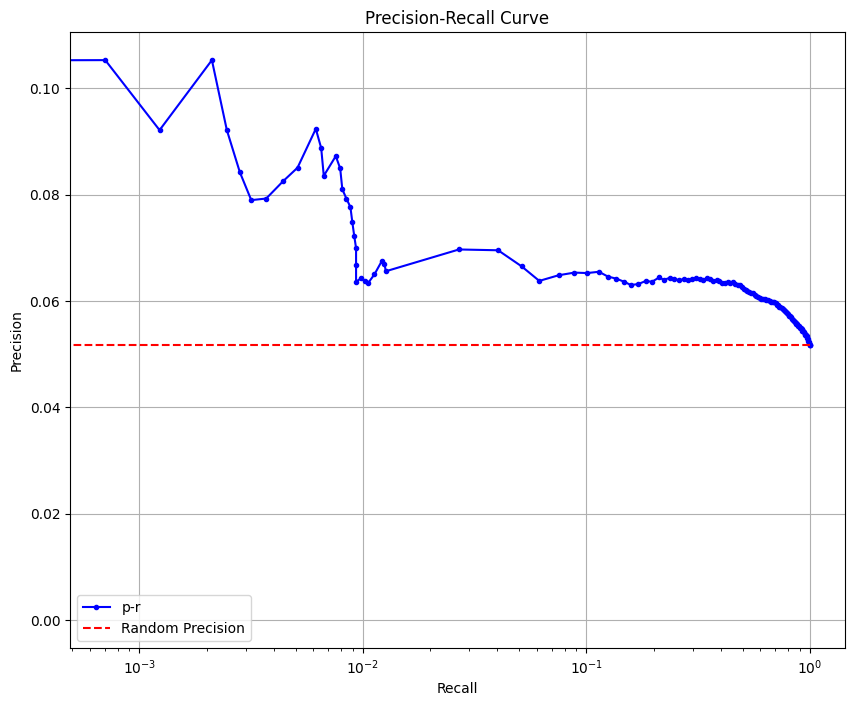

In [21]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
grn = run_deepsem(subadata)
grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_zhao'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [1]:
metrics = {'deepsem_han': {'precision': 0.027305461092218444,
  'recall': 0.9970119521912351,
  'rand_precision': 0.02738729564094637,
  'auprc': 0.026767613473237528,
  'ap': 0.02680245840883502,
  'epr': 0.9426301607414935},
 'deepsem_han_base': {'TF_enr': False,
  'enriched_terms_Regulators': ['celltype.gmt__Beta cells'],
  'enriched_terms_Targets': ['celltype.gmt__Embryonic stem cells'],
  'significant_enriched_TFtargets': 32.075471698113205,
  'precision': 0.0015159632226418483,
  'recall': 0.9999068641147434,
  'rand_precision': 0.0015161044263697398,
  'auprc': 0.001478421383902492,
  'ap': 0.0014790992695324118,
  'epr': 0.9520428965974892},
 'deepsem_han_chip': {'precision': 0.2533531096463195,
  'recall': 0.9995187865722205,
  'rand_precision': 0.25347508526095464,
  'auprc': 0.23803000381222295,
  'ap': 0.2380750578278785,
  'epr': 0.860149919938969},
 'deepsem_han_ko': {'precision': 0.07581693329816405,
  'recall': 0.998577723891907,
  'rand_precision': 0.07592491949717377,
  'auprc': 0.07040045637878578,
  'ap': 0.07042573508694729,
  'epr': 0.8970970305122886},
 'deepsem_mine': {'precision': 0.03629649471911832,
  'recall': 0.7332817935833011,
  'rand_precision': 0.031708871620130905,
  'auprc': 0.03720113854079027,
  'ap': 0.038330641321229576,
  'epr': 1.5505429153841288},
 'deepsem_mine_base': {'TF_enr': False,
  'enriched_terms_Regulators': ['celltype.gmt__Embryonic stem cells'],
  'significant_enriched_TFtargets': 5.0,
  'precision': 0.0015285901821992564,
  'recall': 0.9999182939782661,
  'rand_precision': 0.0015287150874274144,
  'auprc': 0.0016958332661936167,
  'ap': 0.0016959301848768786,
  'epr': 1.4450443156275383},
 'genie3_mine_base': {'TF_enr': False,
  'enriched_terms_Targets': ['celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Epiblast cells',
   'celltype.gmt__Hepatic stellate cells'],
  'significant_enriched_TFtargets': 0.0,
  'precision': 0.0017214396758622867,
  'recall': 0.5969441947871558,
  'rand_precision': 0.0015287150874274144,
  'auprc': 0.0017158869265422312,
  'ap': 0.0017559649503738712,
  'epr': 1.5525935294239963},
 'deepsem_tran': {'precision': 0.04045052962671724,
  'recall': 0.9977181973759269,
  'rand_precision': 0.0405430408437023,
  'auprc': 0.05403877408098963,
  'ap': 0.05415192816564517,
  'epr': 1.9672764697552778},
 'deepsem_tran_chip': {'precision': 0.19809205251553416,
  'recall': 0.9996206972848247,
  'rand_precision': 0.19816721787933453,
  'auprc': 0.19377059289825838,
  'ap': 0.19392160430151847,
  'epr': 0.9616691949004008},
 'deepsem_tran_ko': {'precision': 0.0818837156028978,
  'recall': 0.9985377883503197,
  'rand_precision': 0.08200362225467457,
  'auprc': 0.0916803884227426,
  'ap': 0.09172729484913142,
  'epr': 1.340599776915968},
 'deepsem_zhao': {'precision': 0.05164999362233277,
  'recall': 0.9980633802816902,
  'rand_precision': 0.05175021410739992,
  'auprc': 0.061356203668554266,
  'ap': 0.06146651125729614,
  'epr': 1.280078655468565}}

In [22]:
metrics

{'deepsem_han': {'precision': 0.027305461092218444,
  'recall': 0.9970119521912351,
  'rand_precision': 0.02738729564094637,
  'auprc': 0.026767613473237528,
  'ap': 0.02680245840883502,
  'epr': 0.9426301607414935},
 'deepsem_han_base': {'TF_enr': False,
  'enriched_terms_Regulators': ['celltype.gmt__Beta cells'],
  'enriched_terms_Targets': ['celltype.gmt__Embryonic stem cells'],
  'significant_enriched_TFtargets': 32.075471698113205,
  'precision': 0.0015159632226418483,
  'recall': 0.9999068641147434,
  'rand_precision': 0.0015161044263697398,
  'auprc': 0.001478421383902492,
  'ap': 0.0014790992695324118,
  'epr': 0.9520428965974892},
 'deepsem_han_chip': {'precision': 0.2533531096463195,
  'recall': 0.9995187865722205,
  'rand_precision': 0.25347508526095464,
  'auprc': 0.23803000381222295,
  'ap': 0.2380750578278785,
  'epr': 0.860149919938969},
 'deepsem_han_ko': {'precision': 0.07581693329816405,
  'recall': 0.998577723891907,
  'rand_precision': 0.07592491949717377,
  'auprc'

In [3]:
import pandas as pd

In [4]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append([k.split('_')[-2], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    elif k.split('_')[-1] == "ko":
        res.append([k.split('_')[-2]+"_ko", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    elif k.split('_')[-1] == "chip":
        res.append([k.split('_')[-2]+"_chip", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    else:
        res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,han,0.942630,0.026768,0.027387,False
1,han_chip,0.860150,0.238030,0.253475,False
2,han_ko,0.897097,0.070400,0.075925,False
3,mine,1.550543,0.037201,0.031709,False
4,tran,1.967276,0.054039,0.040543,False
5,tran_chip,0.961669,0.193771,0.198167,False
6,tran_ko,1.340600,0.091680,0.082004,False
7,zhao,1.280079,0.061356,0.051750,False


In [5]:
df2

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,han,0.952043,0.001478,0.001516,32.075472,False,False
1,mine,1.445044,0.001696,0.001529,5.000000,False,False
2,mine,1.552594,0.001716,0.001529,0.000000,False,False
